# Practice 1. implement bilinear interpolation with deconvolution

In [1]:
# libraries for plot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# libraries for torch
import torch
import torch.nn as nn
import torch.nn.functional as F

### draw input image that have a circle with radius=3 and centered at (5, 5)

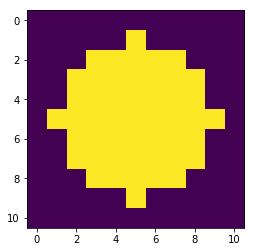

In [3]:
X = torch.zeros(11,11)

# draw a circle by filling ones
cx, cy, r = 5, 5, 4
for i in range(cx-r,cx+r+1):
    for j in range(cy-r, cy+r+1):
        if (i-cx)*(i-cx) + (j-cy)*(j-cy) <= r*r:
            X[j,i] = 1

# showing rectangle
plt.imshow(X)

### simple edge filter

In [4]:
# declare a 2-D convolution filter
Nedge = nn.Conv2d(1,1,3,1,1) # in_channel, out_channel, kernel_size, stride, padding
print(Nedge.weight.size(), Nedge.bias.size()) # model parameter, weight & bias are randomly initialized.

torch.Size([1, 1, 3, 3]) torch.Size([1])


In [5]:
# sobel filter
Fedge = torch.FloatTensor([[1,2,1],[0,0,0],[-1,-2,-1]])/4
Nedge.weight[0,0,:,:] = Fedge
Nedge.bias[0] = 0

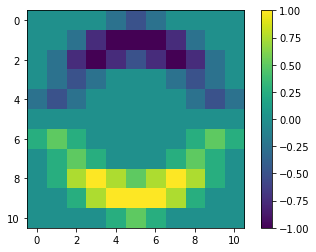

In [6]:
# make 4-D tensor
Xt = X.unsqueeze(0)
Xt.unsqueeze_(0)

Yt = Nedge.forward(Xt)

Y = Yt.squeeze()
plt.imshow(Y.detach())
plt.colorbar()

### bilinear interpolation in pytorch

In [7]:
Xu_aligned    = F.upsample(Xt, scale_factor=32, mode='bilinear', align_corners=True)
Xu_notaligned = F.upsample(Xt, scale_factor=32, mode='bilinear', align_corners=False)

/home/tackgeun/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [8]:
print(Xt.size(), Xu_aligned.size(), Xu_notaligned.size())

torch.Size([1, 1, 11, 11]) torch.Size([1, 1, 352, 352]) torch.Size([1, 1, 352, 352])


Text(0.5,1,'upsampling not aligned')

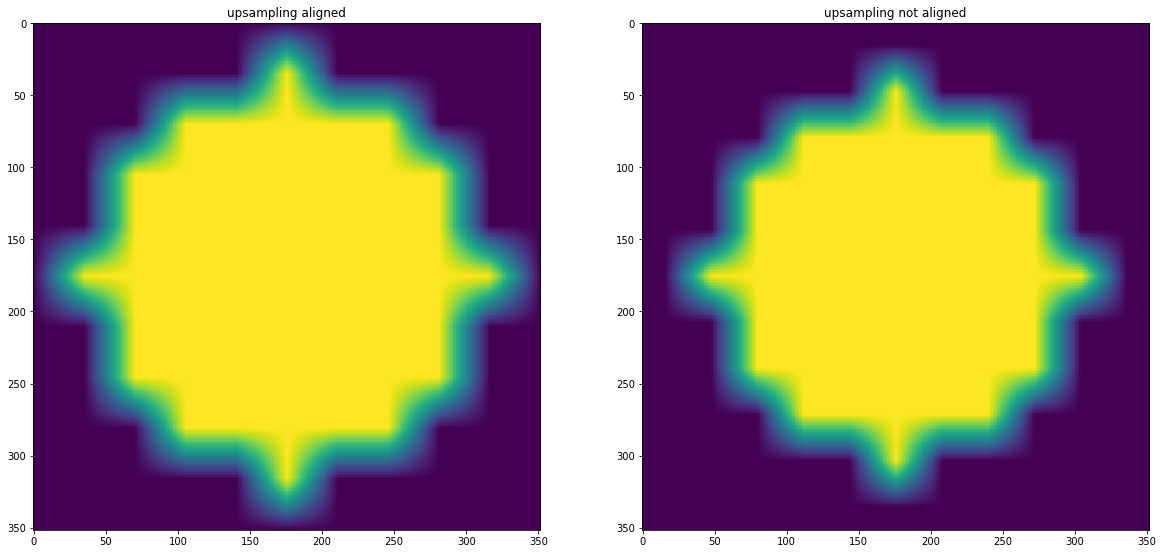

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(Xu_aligned.squeeze().detach())
plt.title('upsampling aligned')

plt.subplot(1,2,2)
plt.imshow(Xu_notaligned.squeeze().detach())
plt.title('upsampling not aligned')

### Implement bilinear interpolation with deconvolution
- https://en.wikipedia.org/wiki/Bilinear_interpolation

In [10]:
Fbi = torch.zeros(64,64)
# F = A B
#     C D

# A
for j in range(0,32):
    for i in range(0, 32):
        Fbi[j,i] = (i/32)*(j/32)

# B
for j in range(0,32):
    for i in range(32, 64):
        Fbi[j,i] = ((64-i)/32)*(j/32)
        
# C
for j in range(32,64):
    for i in range(0, 32):
        Fbi[j,i] = (i/32)*((64-j)/32)

# D
for j in range(32,64):
    for i in range(32, 64):
        Fbi[j,i] = ((64-i)/32)*((64-j)/32)    

#### Filter Visualization

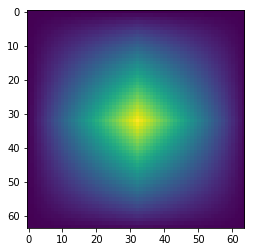

In [11]:
plt.imshow(Fbi)

In [12]:
S = Fbi[0:32,0:32] + Fbi[0:32,32:64] + Fbi[32:64,0:32] + Fbi[32:64,32:64]
print(S.max(), S.min())

tensor(1.) tensor(1.)


In [13]:
Nbi = nn.ConvTranspose2d(1,1,64,32,16)
Nbi.weight.data = Fbi.view(1,1,64,64)
Nbi.bias.data = torch.zeros(Nbi.bias.data.size())

In [14]:
Xub = Nbi.forward(Xt).detach().squeeze()

Text(0.5,1,'deconvolution, padding 16')

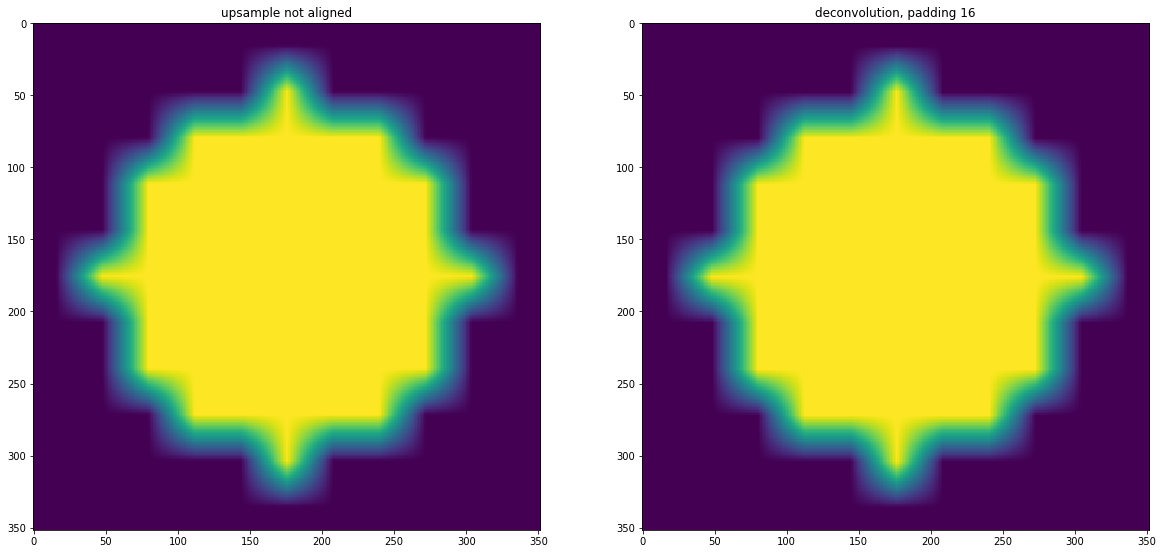

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(Xu_notaligned.squeeze().detach())
plt.title('upsample not aligned')
plt.subplot(1,2,2)
plt.imshow(Xub.numpy())
plt.title('deconvolution, padding 16')